In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import datetime
import sys
sys.path.append('..')
import src.tools as tools

In [2]:
#RFM Libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import kruskal

#CLTV Libraries:
from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [3]:
a = pd.read_csv('../data/Year 2009-2010.csv', encoding='unicode_escape')
b = pd.read_csv('../data/Year 2010-2011.csv', encoding='unicode_escape')
retail = pd.concat([a,b], ignore_index=True)

In [4]:
retail.columns= retail.columns.str.lower()
retail.drop_duplicates(inplace=True)
retail = retail.query("country=='United Kingdom'").reset_index(drop=True)
retail.invoicedate = pd.to_datetime(retail.invoicedate)
retail['year'] = retail.invoicedate.dt.year
retail['month'] = retail.invoicedate.dt.month
retail['week'] = retail.invoicedate.dt.isocalendar().week
retail['day'] = retail.invoicedate.dt.day
retail['hour'] = retail.invoicedate.dt.hour
retail['revenue'] = retail.price * retail.quantity
#retail = retail.query("year>2009").reset_index(drop=True)
retail = retail.query("quantity>0").reset_index(drop=True)
retail = retail.query("price>0").reset_index(drop=True)
retail = retail.dropna()

#### Define customers time

In [5]:
min_date = retail.groupby(['customer id'])['invoicedate'].min().reset_index()
max_date = retail.groupby(['customer id'])['invoicedate'].max().reset_index()
min_date.columns = ['customer id', 'min_date']
max_date.columns = ['customer id', 'max_date']
min_date = pd.merge(min_date, max_date, on='customer id')
min_date['customer_months'] = min_date['max_date'] - min_date['min_date']
min_date['customer_months'] = min_date['customer_months'] / np.timedelta64(1,'M')
min_date['customer_months'] = min_date['customer_months'].astype(int)
min_date.drop(columns=['min_date','max_date'], inplace=True)
retail = pd.merge(retail, min_date, on='customer id')
retail.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,49,1,7,83.4,19
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,49,1,7,81.0,19
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,49,1,7,81.0,19
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,49,1,7,100.8,19
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,49,1,7,30.0,19


In [6]:
retail.customer_months.describe()

count    700388.000000
mean         16.152206
std           7.573422
min           0.000000
25%          11.000000
50%          19.000000
75%          23.000000
max          24.000000
Name: customer_months, dtype: float64

In [7]:
(retail.customer_months.value_counts(normalize=True)*100).sort_index()

0      5.924573
1      1.657938
2      1.658938
3      1.936355
4      1.731326
5      1.252020
6      1.343684
7      1.658367
8      1.966767
9      1.457335
10     1.591118
11     2.834143
12     3.810174
13     3.471504
14     2.956219
15     2.288731
16     3.080150
17     3.271615
18     3.580158
19     5.148575
20     6.626042
21     5.734393
22     6.366043
23    18.780590
24     9.873242
Name: customer_months, dtype: float64

#### Analyze 12-months customers

In [8]:
retail2y = retail.query('customer_months==23').reset_index(drop=True)
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
5318,545503,22383,LUNCH BAG SUKI DESIGN,4,2011-03-03 11:34:00,1.65,15719.0,United Kingdom,2011,3,9,3,11,6.60,23
1018,527965,22646,CERAMIC STRAWBERRY CAKE MONEY BANK,12,2010-10-20 09:46:00,1.45,17865.0,United Kingdom,2010,10,42,20,9,17.40,23
80909,512894,21116,OWL DOORSTOP,3,2010-06-18 12:37:00,4.95,13426.0,United Kingdom,2010,6,24,18,12,14.85,23


#### Segmentation

In [9]:
df_2y = tools.rfm(retail2y)
df_2y.sample(3)

,customer id,recency,frequency,monetary
117,14546.0,4,790,5184.84
297,18097.0,7,156,4627.92
41,17377.0,23,1712,17644.27


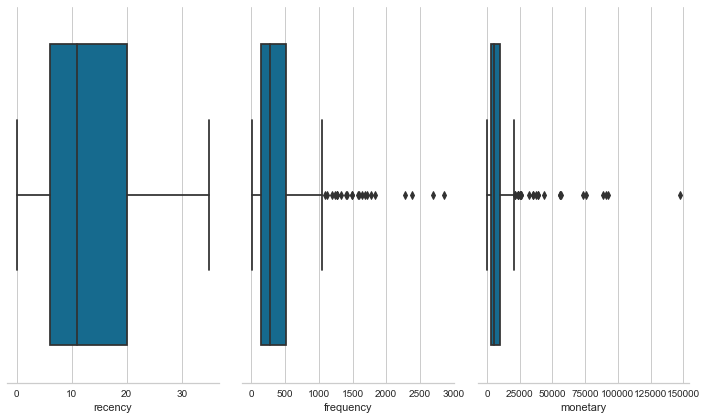

In [10]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.boxplot(x=df_2y.recency, color="b", ax=axes[0])
sns.boxplot(x=df_2y.frequency, color="b", ax=axes[1])
sns.boxplot(x=df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [11]:
df_2y['z_recency'] = stats.zscore(df_2y.recency)
df_2y['z_frequency'] = stats.zscore(df_2y.frequency)
df_2y['z_monetary'] = stats.zscore(df_2y.monetary)
df_2y.shape

(315, 7)

In [12]:
df_2y = df_2y[(df_2y.z_recency >= -3) & (df_2y.z_recency <= 3) &
         (df_2y.z_frequency >= -3) & (df_2y.z_frequency <= 3) &
         (df_2y.z_monetary >= -3) & (df_2y.z_monetary <= 3)]

In [13]:
df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,13.006623,377.910596,7012.606825,0.004648,-0.091572,-0.152257
std,8.958373,341.943005,6776.745802,1.002400,0.789377,0.453730
min,0.000000,9.000000,229.500000,-1.450732,-0.943204,-0.606412
25%,6.000000,145.000000,2753.925000,-0.779360,-0.629247,-0.437392
50%,12.000000,266.500000,4877.695000,-0.107988,-0.348764,-0.295197
75%,20.000000,493.000000,9027.152500,0.787175,0.174113,-0.017375
max,35.000000,1712.000000,43515.051000,2.465604,2.988181,2.291726


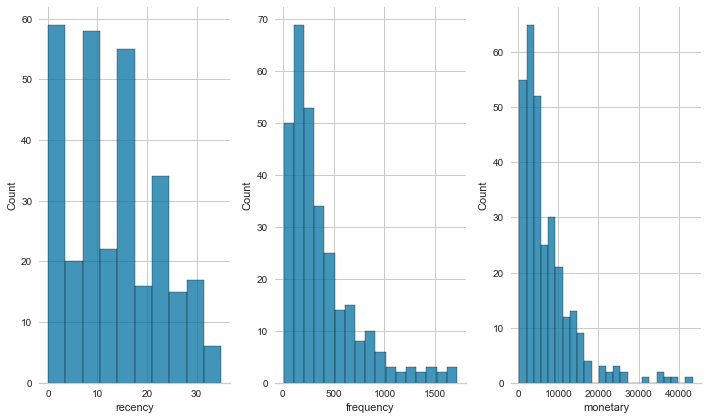

In [14]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.histplot(df_2y.recency, color="b", ax=axes[0])
sns.histplot(df_2y.frequency, color="b", ax=axes[1])
sns.histplot(df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [15]:
print(stats.jarque_bera(df_2y.recency)[1] < 0.05)
print(stats.jarque_bera(df_2y.frequency)[1] < 0.05)
print(stats.jarque_bera(df_2y.monetary)[1] < 0.05)

True
True
True


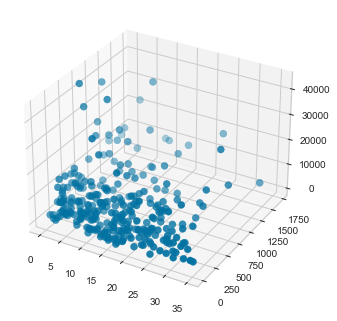

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

plt.show()

#### Define number of clusters using elbow method

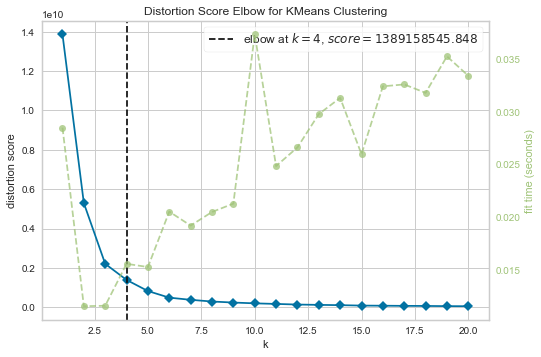

In [17]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,21))

visualizer.fit(df_2y[['recency', 'frequency', 'monetary']])
visualizer.show();

#### Run clustering based on Recency, Frequency and Money

In [18]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_2y[['recency', 'frequency', 'monetary']])
df_2y['clusters'] = kmeans.predict(df_2y[['recency', 'frequency', 'monetary']])
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters
23,13381.0,31,356,8224.37,2.018023,-0.142153,-0.071124,3
104,13021.0,3,257,4887.24,-1.115046,-0.370695,-0.294558,0
91,14961.0,10,670,16410.15,-0.331778,0.582718,0.476946,2


In [19]:
(df_2y.clusters.value_counts(normalize=True)*100).sort_index()

0    61.920530
1     1.986755
2     8.609272
3    27.483444
Name: clusters, dtype: float64

In [20]:
df_2y.drop(columns='customer id').groupby(['clusters']).median()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
clusters,,,,,,
0,14.0,196.0,3140.54,0.115803,-0.511514,-0.411507
1,3.5,720.5,36437.86,-1.059098,0.699298,1.817880
2,9.5,731.5,17059.95,-0.387726,0.724691,0.520453
3,11.0,466.0,9502.26,-0.219883,0.111783,0.014435


In [21]:
weighted = df_2y.drop(columns='customer id').groupby(['clusters']).median()
weighted['recency'] = weighted['recency']/weighted['recency'].min()
weighted['frequency'] = weighted['frequency']/weighted['frequency'].max()
weighted['monetary'] = weighted['monetary']/weighted['monetary'].max()
weighted['segment'] = (weighted.frequency * weighted.monetary) / weighted.recency
weighted['segment'] = weighted.segment.rank(ascending=False)
weighted.sort_values(by='segment')

,recency,frequency,monetary,z_recency,z_frequency,z_monetary,segment
clusters,,,,,,,
1,1.000000,0.984962,1.000000,-1.059098,0.699298,1.817880,1.0
2,2.714286,1.000000,0.468193,-0.387726,0.724691,0.520453,2.0
3,3.142857,0.637047,0.260780,-0.219883,0.111783,0.014435,3.0
0,4.000000,0.267943,0.086189,0.115803,-0.511514,-0.411507,4.0


In [22]:
df_2y = pd.merge(df_2y, weighted['segment'], on='clusters')
df_2y.drop(columns=['clusters', 'z_recency', 'z_frequency','z_monetary'], inplace=True)
df_2y.sample(3)

,customer id,recency,frequency,monetary,segment
218,12747.0,1,249,8898.48,3.0
0,17519.0,16,204,4774.17,4.0
81,18219.0,2,190,3352.70,4.0


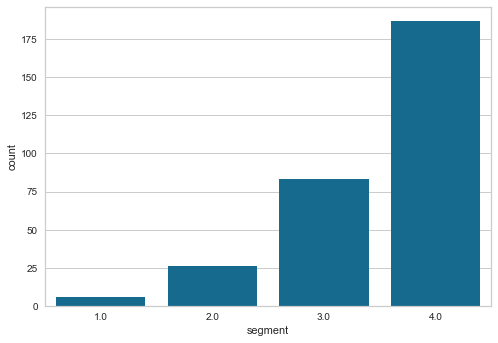

In [23]:
sns.countplot(x=df_2y.segment, color="b");

In [24]:
df_2y.segment.value_counts(normalize=True)*100

4.0    61.920530
3.0    27.483444
2.0     8.609272
1.0     1.986755
Name: segment, dtype: float64

In [25]:
retail2y = pd.merge(retail2y, df_2y[['customer id', 'segment']], on='customer id')
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months,segment
65834,503777,21001,ROSE DU SUD WASHBAG,1,2010-04-07 11:20:00,5.95,13727.0,United Kingdom,2010,4,14,7,11,5.95,23,4.0
94778,511233,20718,RED SPOTTY SHOPPER BAG,10,2010-06-07 12:29:00,1.25,15640.0,United Kingdom,2010,6,23,7,12,12.50,23,2.0
98944,572677,21832,CHOCOLATE CALCULATOR,1,2011-10-25 13:46:00,1.65,17596.0,United Kingdom,2011,10,43,25,13,1.65,23,4.0


In [26]:
seg_rev = retail2y.groupby(['year','month','segment'])['revenue'].sum().unstack().fillna(0)
seg_rev

segment           1.0       2.0       3.0       4.0
year month                                         
2009 12     13109.080  34486.99  56953.74  69923.46
2010 1      12538.171  13294.50  28118.26  21854.12
     2       5044.110  17023.34  29843.83  14574.89
     3       8822.250  19070.32  32316.88  21487.62
     4      10336.080  24498.55  30234.86  16430.24
     5       6933.110  19336.79  32153.56  16202.75
     6       8673.940  21550.22  28799.62  21744.99
     7      10307.350  16264.71  26102.80  18121.18
     8       6830.260  21418.51  30425.26  17418.38
     9      19240.830  14894.59  36954.68  23880.43
     10     10206.170  25979.37  40129.87  33721.52
     11     13180.150  39016.81  64289.43  53590.94
     12      7024.190  20841.33  41915.65  32449.42
2011 1       6496.890  12101.20  26595.71  14571.16
     2       7911.610  15081.74  20896.47  10537.42
     3       6319.330  12087.13  22791.21  15258.97
     4       4997.280  14663.83  21215.88  10815.53
     5       8637.240  14224.72  28460.49  15831.21
     6       3823.920  13027.11  25487.61  15763.57
     7       9599.030  11892.09  23206.96  14262.82
     8       7063.530  19301.42  24463.59  14798.25
     9      10029.610  21797.92  32015.25  24049.22
     10      9885.530  25112.18  30323.09  25136.75
     11     12799.040  37796.21  58657.94  56247.66
     12      2711.380   7542.08  13862.96  18095.42

In [27]:
retail2y[['invoicedate', 'revenue']]

,invoicedate,revenue
0,2009-12-01 09:57:00,10.20
1,2009-12-01 09:57:00,10.20
2,2009-12-01 09:57:00,20.40
3,2009-12-01 09:57:00,10.20
4,2009-12-01 09:57:00,19.90
...,...,...
114124,2011-11-28 16:35:00,14.85
114125,2011-11-28 16:35:00,25.20
114126,2011-11-28 16:35:00,19.80
114127,2011-11-28 16:35:00,15.00


In [28]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()
cluster1 = retail2y[retail2y.segment == 1]
cluster1 = cluster1[['invoicedate', 'revenue']]
cluster1.shape

(5041, 2)

In [29]:
cluster2 = retail2y[retail2y.segment == 2]
cluster2 = cluster2[['invoicedate', 'revenue']]
cluster2.shape

(18849, 2)

In [30]:
cluster3 = retail2y[retail2y.segment == 3]
cluster3 = cluster3[['invoicedate', 'revenue']]
cluster3.shape

(45947, 2)

In [31]:
cluster4 = retail2y[retail2y.segment == 4]
cluster4 = cluster4[['invoicedate', 'revenue']]
cluster4.shape

(44292, 2)

In [32]:
"""cluster1.to_csv('../data/ts_segment1.csv',index=False)
cluster2.to_csv('../data/ts_segment2.csv',index=False)
cluster3.to_csv('../data/ts_segment3.csv',index=False)
cluster4.to_csv('../data/ts_segment4.csv',index=False)""";

In [33]:
def clean_ts (df):
    df.columns = ['ds','y']
    df.ds = pd.to_datetime(df.ds).dt.strftime('%Y-%m')
    
    df['z_score'] = stats.zscore(df.y)
    df = df[(df.z_score >= -3) & (df.z_score <= 3)]
    df = df.drop(columns='z_score')
    df.set_index('ds', inplace=True)
    return df

In [34]:
k1 = clean_ts(cluster1)
k2 = clean_ts(cluster2)
k3 = clean_ts(cluster3)
k4 = clean_ts(cluster4)

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.despine(left=True)

sns.lineplot(data=k1, x='ds', y='y', color="b", ax=axes[0,0])
sns.lineplot(data=k2, x='ds', y='y', color="b", ax=axes[0,1])
sns.lineplot(data=k3, x='ds', y='y', color="b", ax=axes[1,0])
sns.lineplot(data=k4, x='ds', y='y', color="b", ax=axes[1,1])

plt.show();